In [1]:
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.linalg import spsolve
from fealpy.boundarycondition import DirichletBC, NeumannBC

from fealpy.tools.show import showmultirate, show_error_table


In [2]:
import numpy as np
from fealpy.decorator import cartesian,barycentric
class possion_solution:
    
    def __init__(self):
        pass
    
    # 定义网格区域大小
    @property
    def domain(self):   
        return np.array([0, 0.1, 0, 0.1])
        
    # 原项 f(x,y)，泊松方程的右边
    @cartesian
    def source(self, p):  
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = 2*pi*pi*np.cos(pi*x)*np.cos(pi*y)
        return val
    
    # 精确解u(x,y)，泊松方程的左边
    @cartesian
    def exact_solution(self, p):
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.cos(pi*x)*np.cos(pi*y)
        return val
        
    # 真解的梯度 
    @cartesian
    def gradient(self, p):  
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.zeros(p.shape, dtype = np.float64)
        val[..., 0] = -pi*np.sin(pi*x)*np.cos(pi*y)
        val[..., 1] = -pi*np.cos(pi*x)*np.sin(pi*y)
        return val
        
    # 梯度的负方向
    @cartesian 
    def flux(self, p):
        return -self.gradient(p)
        
    #定义边界条件
    @cartesian
    def is_dirichlet_boundary(self, p):
        y = p[..., 1]
        return (y == 0.0) 
    
    @cartesian
    def dirichlet(self, p):
        return self.exact_solution(p)
    
    @cartesian
    def is_neumann_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (x == 0.0)|(x == 0.1)|(y == 0.1)
        
    @cartesian
    def neumann(self, p, n):
        grad = self.gradient(p)
        val = np.sum(grad * n, axis = -1)
        return val


run boxmesh2d with time: 0.0007217999999999947


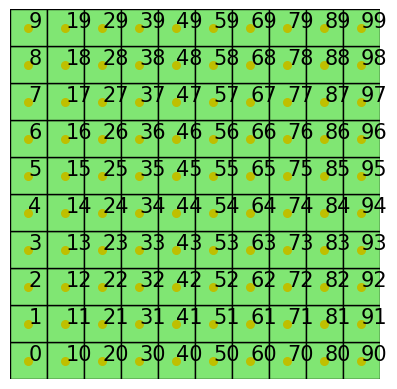

In [3]:
import numpy as np
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
%matplotlib inline

# 加载pde模型
pde = possion_solution()

# 加载网格
box = pde.domain
mesh = MeshFactory.boxmesh2d(box, nx = 10, ny = 10, meshtype = 'quad')

# 画图
figure = plt.figure()
axes = figure.gca()
mesh.add_plot(axes)
#mesh.find_node(axes, showindex = True)
#mesh.find_edge(axes, showindex = True)
mesh.find_cell(axes, showindex = True)

#获取单元，网格，节点信息
nodes = mesh.entity('node')
cells = mesh.entity('cell')
edges = mesh.entity('edge')


In [15]:
import sys
def possion_solution_solver(pde, n, refine, order): 
    """
    Input:
        @pde: 定义偏微分方程
        @n: 初始网格剖分段数
        @refine: 网格加密的最大次数（迭代求解次数）
        @order: 有限元多项式次数
    Output: None
    """
    mesh = MeshFactory.boxmesh2d(pde.domain, nx = n, ny = n, meshtype = 'tri')
    
    number_of_dofs = np.zeros(refine, dtype = mesh.itype)
    # 建立空数组，目的把每组的自由度个数存下来
    error_matrix = np.zeros((2, refine), dtype = mesh.ftype)
    error_type = ['$||u - u^{h}||_{0}$', '$||\\nabla u - \\nabla u^{h}||_{0}$']
    
    for i in range(refine):
        femspace = LagrangeFiniteElementSpace(mesh, p = order)
        number_of_dofs[i] = femspace.number_of_global_dofs()
        uh = femspace.function() 
        # 返回一个有限元函数，初始自由度值全为 0
        
        # A·u = b + b_n
        
        A = femspace.stiff_matrix()
        F = femspace.source_vector(pde.source)
        # 先计算纽曼
        bc = NeumannBC(femspace, pde.neumann, threshold = pde.is_neumann_boundary)
        F = bc.apply(F)
        
        #最后计算Dirichlet
        bc = DirichletBC(femspace, pde.dirichlet, threshold = pde.is_dirichlet_boundary)
        A, F = bc.apply(A, F, uh)
        
        uh[:] = spsolve(A, F)
        
        #计算误差
        error_matrix[0, i] = femspace.integralalg.L2_error(pde.exact_solution, uh.value)
        error_matrix[1, i] = femspace.integralalg.L2_error(pde.gradient, uh.grad_value)
        
        print('插值点: ', femspace.interpolation_points().shape)
        print('自由度数（NDof）: ', number_of_dofs[i])
        nodes = mesh.entity('node')
        print('节点数: ', nodes.shape)
        if i < refine - 1:
            mesh.uniform_refine()
    
    fig = plt.figure()
    axes = fig.add_subplot(projection='3d')
    uh.add_plot(axes, cmap = 'rainbow')
    showmultirate(plt, 0, number_of_dofs, error_matrix, error_type, propsize = 20)
    show_error_table(number_of_dofs, error_type, error_matrix, f='e', pre=4, sep=' & ', out=sys.stdout, end='\n')
    plt.show()


run boxmesh2d with time: 0.0006474000000480373
run serial_construct_matrix with time: 0.0034572999999795684
插值点:  (121, 2)
自由度数（NDof）:  121
节点数:  (121, 2)
run serial_construct_matrix with time: 0.009930699999983972
插值点:  (441, 2)
自由度数（NDof）:  441
节点数:  (441, 2)
run serial_construct_matrix with time: 0.03813440000004675
插值点:  (1681, 2)
自由度数（NDof）:  1681
节点数:  (1681, 2)
run serial_construct_matrix with time: 0.14769669999998314
插值点:  (6561, 2)
自由度数（NDof）:  6561
节点数:  (6561, 2)
run serial_construct_matrix with time: 0.5790546000000063
插值点:  (25921, 2)
自由度数（NDof）:  25921
节点数:  (25921, 2)
\begin{table}[!htdp]
\begin{tabular}[c]{|c|c|c|c|c|c|}\hline
Dof &   121 &   441 &  1681 &  6561 & 25921
\\\hline
$||u - u^{h}||_{0}$ & 1.7484e-05 & 4.3838e-06 & 1.0969e-06 & 2.7431e-07 & 6.8583e-08
\\\hline
Order & -- & 2. & 2. & 2. & 2.
\\\hline
$||\nabla u - \nabla u^{h}||_{0}$ & 3.7944e-03 & 1.9014e-03 & 9.5133e-04 & 4.7576e-04 & 2.3789e-04
\\\hline
Order & -- & 1. & 1. & 1. & 1.
\\\hline
\end{tabular}

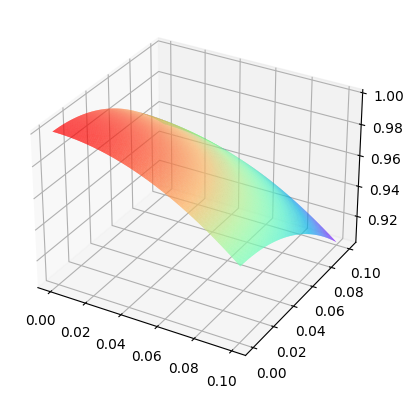

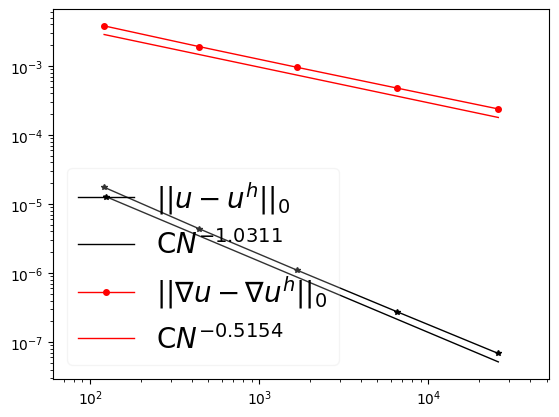

In [16]:
possion_solution_solver(possion_solution(), 10, 5, 1)


run boxmesh2d with time: 0.0006675999999856685
run serial_construct_matrix with time: 0.008003200000018751
插值点:  (441, 2)
自由度数（NDof）:  441
节点数:  (121, 2)
run serial_construct_matrix with time: 0.02712399999995796
插值点:  (1681, 2)
自由度数（NDof）:  1681
节点数:  (441, 2)
run serial_construct_matrix with time: 0.10604210000002467
插值点:  (6561, 2)
自由度数（NDof）:  6561
节点数:  (1681, 2)
run serial_construct_matrix with time: 0.442288700000006
插值点:  (25921, 2)
自由度数（NDof）:  25921
节点数:  (6561, 2)
run serial_construct_matrix with time: 1.7352286000000277
插值点:  (103041, 2)
自由度数（NDof）:  103041
节点数:  (25921, 2)
\begin{table}[!htdp]
\begin{tabular}[c]{|c|c|c|c|c|c|}\hline
Dof &    441 &   1681 &   6561 &  25921 & 103041
\\\hline
$||u - u^{h}||_{0}$ & 1.2474e-08 & 1.5820e-09 & 1.9929e-10 & 2.5012e-11 & 3.3612e-12
\\\hline
Order & -- & 2.98 & 2.99 & 2.99 & 2.9 
\\\hline
$||\nabla u - \nabla u^{h}||_{0}$ & 9.4860e-06 & 2.4065e-06 & 6.0599e-07 & 1.5204e-07 & 3.8078e-08
\\\hline
Order & -- & 1.98 & 1.99 & 1.99 & 2.  

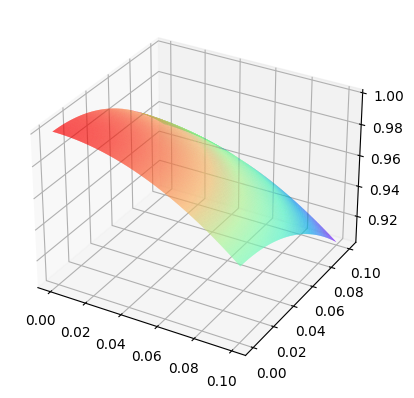

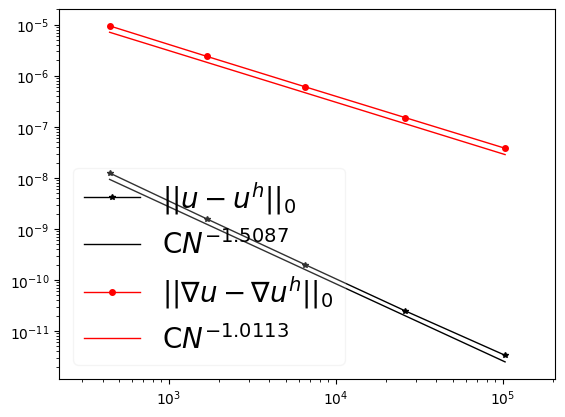

In [17]:
possion_solution_solver(possion_solution(), 10, 5, 2)


In [14]:
def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (y == 0.0) & ( x <b) & (x > a) 
    
@cartesian
def dirichlet(self, p):
    val = val * np.ones(len(p))
    return val
